# Billboard Hot 100 Chart Data Analysis and Exploration


Samantha Cabral
DSC 530 - Data Exploration and Analysis
Prof. Metzger
Due: November 17, 2024
Final Term Project


Data Set:

Billboard Hot 100 (Top 100) Songs each week from August 4, 1958 through November 6, 2021.

Statistical Question:

Do songs that debut in the top 10 stay on the chart longer than songs that debut between ranks 11 and 100?

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import mode, skew, expon, pearsonr, spearmanr
from collections import Counter

In [3]:
#Load the Dataset

charts_df = pd.read_csv('charts.csv')
print(charts_df.info())
print(charts_df.describe())
charts_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330087 entries, 0 to 330086
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   date            330087 non-null  object 
 1   rank            330087 non-null  int64  
 2   song            330087 non-null  object 
 3   artist          330087 non-null  object 
 4   last-week       297775 non-null  float64
 5   peak-rank       330087 non-null  int64  
 6   weeks-on-board  330087 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 17.6+ MB
None
                rank      last-week      peak-rank  weeks-on-board
count  330087.000000  297775.000000  330087.000000   330087.000000
mean       50.500929      47.591631      40.970629        9.161785
std        28.866094      28.054360      29.347481        7.618264
min         1.000000       1.000000       1.000000        1.000000
25%        26.000000      23.000000      13.000000        4.000000
50%   

,date,rank,song,artist,last-week,peak-rank,weeks-on-board
0,2021-11-06,1,Easy On Me,Adele,1.0,1,3
1,2021-11-06,2,Stay,The Kid LAROI & Justin Bieber,2.0,1,16
2,2021-11-06,3,Industry Baby,Lil Nas X & Jack Harlow,3.0,1,14
3,2021-11-06,4,Fancy Like,Walker Hayes,4.0,3,19
4,2021-11-06,5,Bad Habits,Ed Sheeran,5.0,2,18


In [4]:
#Convert "date" column to datetime type
charts_df['date'] = pd.to_datetime(charts_df['date'])

print(charts_df.info())
charts_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330087 entries, 0 to 330086
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            330087 non-null  datetime64[ns]
 1   rank            330087 non-null  int64         
 2   song            330087 non-null  object        
 3   artist          330087 non-null  object        
 4   last-week       297775 non-null  float64       
 5   peak-rank       330087 non-null  int64         
 6   weeks-on-board  330087 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 17.6+ MB
None


,date,rank,song,artist,last-week,peak-rank,weeks-on-board
0,2021-11-06,1,Easy On Me,Adele,1.0,1,3
1,2021-11-06,2,Stay,The Kid LAROI & Justin Bieber,2.0,1,16
2,2021-11-06,3,Industry Baby,Lil Nas X & Jack Harlow,3.0,1,14
3,2021-11-06,4,Fancy Like,Walker Hayes,4.0,3,19
4,2021-11-06,5,Bad Habits,Ed Sheeran,5.0,2,18


In [5]:
#Create "debut_top_10" DataFrame that only contains data for songs that fit these criteria:
#-'weeks-on-board' is '1'
#-'rank' is <= 10

debut_top_10 = charts_df[(charts_df['weeks-on-board'] == 1) & (charts_df['rank'] <= 10)]


#Create "debut_11_100" DataFrame that only contains data for songs that fit these criteria:
#-'weeks-on-board' is '1'
#-'rank' is > 10

debut_11_100 = charts_df[(charts_df['weeks-on-board'] == 1) & (charts_df['rank'] > 10)]


# Preview the groups
print(f"Top 10 Debuts: {debut_top_10.shape[0]} songs")
print(f"11-100 Debuts: {debut_11_100.shape[0]} songs")

Top 10 Debuts: 355 songs
11-100 Debuts: 29329 songs


In [6]:
debut_top_10.head()

,date,rank,song,artist,last-week,peak-rank,weeks-on-board
400,2021-10-09,1,My Universe,Coldplay x BTS,NaN,1,1
509,2021-10-02,10,Thats What I Want,Lil Nas X,NaN,10,1
700,2021-09-18,1,Way 2 Sexy,Drake Featuring Future & Young Thug,NaN,1,1
701,2021-09-18,2,Girls Want Girls,Drake Featuring Lil Baby,NaN,2,1
702,2021-09-18,3,Fair Trade,Drake Featuring Travis Scott,NaN,3,1


In [7]:
debut_11_100.head()

,date,rank,song,artist,last-week,peak-rank,weeks-on-board
26,2021-11-06,27,Moth To A Flame,Swedish House Mafia & The Weeknd,NaN,27,1
27,2021-11-06,28,Let's Go Brandon,Bryson Gray Featuring Tyson James & Chandler C...,NaN,28,1
60,2021-11-06,61,Not In The Mood,"Lil Tjay, Fivio Foreign & Kay Flock",NaN,61,1
68,2021-11-06,69,Switches & Dracs,Moneybagg Yo Featuring Lil Durk & EST Gee,NaN,69,1
78,2021-11-06,79,Poke It Out,Wale Featuring J. Cole,NaN,79,1


In [8]:
#Find the largest 'weeks-on-board' value for songs in a DataFrame. 

def songLongevity(charts_df, debut_df):
    """
    charts_df: Original dataset containing chart information
    debut_df: DataFrame containing songs that should be compared to charts_df
      - in this case, we will compare songs in the debut_top_10 or debut_11_100 dfs
    
    filters songs to remove repeated song data for weeks other than their final week
    
    returns a DataFrame containing rows of data for songs during their final appearance on the chart
    based on the return of the largest value in 'weeks-on-board' for songs that appear in the debut_df
    """
    
    filtered_songs = charts_df[
        charts_df['song'].isin(debut_df['song']) & charts_df['artist'].isin(debut_df['artist'])
    ]
    
    last_appearance = filtered_songs.loc[
        filtered_songs.groupby(['song', 'artist'])['weeks-on-board'].idxmax()
    ]
    
    return last_appearance

In [9]:
top10_last_apperance_df = songLongevity(charts_df, debut_top_10)
top10_last_apperance_df.head()

,date,rank,song,artist,last-week,peak-rank,weeks-on-board
19795,2018-01-27,96,...Ready For It?,Taylor Swift,80.0,4,20
7845,2020-05-09,46,"10,000 Hours",Dan + Shay & Justin Bieber,41.0,4,30
124148,1998-01-24,49,2 Become 1,Spice Girls,44.0,4,24
22249,2017-08-05,50,24K Magic,Bruno Mars,48.0,4,41
60971,2010-03-06,72,3,Britney Spears,63.0,1,20


In [10]:
bottom90_last_apperance_df = songLongevity(charts_df, debut_11_100)
bottom90_last_apperance_df.head()

,date,rank,song,artist,last-week,peak-rank,weeks-on-board
163090,1990-08-11,91,"""B"" Girls",Young And Restless,83.0,54,15
252937,1973-05-19,51,"""Cherry Cherry"" from Hot August Night",Neil Diamond,31.0,31,10
250048,1973-12-08,62,"""Having A Party"" Medley",The Ovations (Featuring Louis Williams),56.0,56,9
249028,1974-02-16,42,"""Joy"" Pt. I",Isaac Hayes,30.0,30,9
232582,1977-04-16,83,"""Roots"" Medley",Quincy Jones,57.0,57,7


In [11]:
#Create a Dataframe for all songs in the dataset and the information contained for that song's
#debut week

all100_first_apperance_df = pd.concat([debut_top_10, debut_11_100], axis=0)


#Create a DataFrame for all songs in the dataset, regardless of debut, that contains the largest
#'weeks-on-board' number

all100_last_apperance_df = pd.concat([top10_last_apperance_df, bottom90_last_apperance_df], axis=0)


In [12]:
all100_first_apperance_df.head()

,date,rank,song,artist,last-week,peak-rank,weeks-on-board
400,2021-10-09,1,My Universe,Coldplay x BTS,NaN,1,1
509,2021-10-02,10,Thats What I Want,Lil Nas X,NaN,10,1
700,2021-09-18,1,Way 2 Sexy,Drake Featuring Future & Young Thug,NaN,1,1
701,2021-09-18,2,Girls Want Girls,Drake Featuring Lil Baby,NaN,2,1
702,2021-09-18,3,Fair Trade,Drake Featuring Travis Scott,NaN,3,1


In [13]:
all100_last_apperance_df.head()

,date,rank,song,artist,last-week,peak-rank,weeks-on-board
19795,2018-01-27,96,...Ready For It?,Taylor Swift,80.0,4,20
7845,2020-05-09,46,"10,000 Hours",Dan + Shay & Justin Bieber,41.0,4,30
124148,1998-01-24,49,2 Become 1,Spice Girls,44.0,4,24
22249,2017-08-05,50,24K Magic,Bruno Mars,48.0,4,41
60971,2010-03-06,72,3,Britney Spears,63.0,1,20


In [14]:
import thinkplot
import thinkstats2

Creating a Histogram for each of the 5 Variables

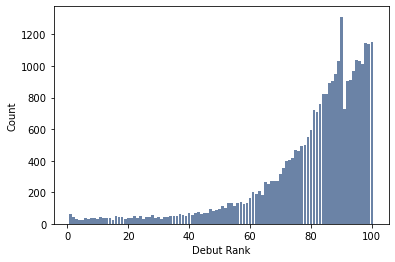

In [15]:
debut_rank = all100_first_apperance_df['rank'].value_counts().to_dict()

dr_hist = thinkstats2.Hist(debut_rank)
thinkplot.Hist(dr_hist)
thinkplot.Config(xlabel='Debut Rank', ylabel='Count')

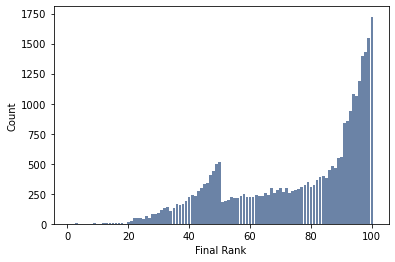

In [16]:
final_rank = all100_last_apperance_df['rank'].value_counts().to_dict()

fr_hist = thinkstats2.Hist(final_rank)
thinkplot.Hist(fr_hist)
thinkplot.Config(xlabel='Final Rank', ylabel='Count')

In [17]:
def findLongevityCount(debut_df):
    """
    debut_df: DataFrame that has been filtered by debut ranking
    
    returns dictionary of key, value pairs ('weeks-on-board', count)
    """
    longevity_count = debut_df['weeks-on-board'].value_counts().to_dict()
    
    return longevity_count

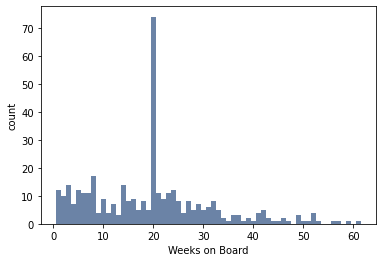

In [18]:
top10_longevity = findLongevityCount(top10_last_apperance_df)

t10_hist = thinkstats2.Hist(top10_longevity)
thinkplot.Hist(t10_hist)
thinkplot.Config(xlabel='Weeks on Board', ylabel='count')

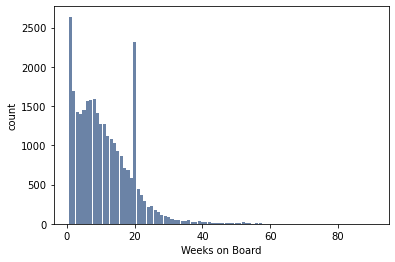

In [19]:
bottom90_longevity = findLongevityCount(bottom90_last_apperance_df)

b90_hist = thinkstats2.Hist(bottom90_longevity)
thinkplot.Hist(b90_hist)
thinkplot.Config(xlabel='Weeks on Board', ylabel='count')

In [20]:
print(bottom90_longevity)

{1: 2639, 20: 2317, 2: 1691, 8: 1587, 7: 1578, 6: 1563, 5: 1444, 3: 1420, 9: 1415, 4: 1396, 11: 1267, 10: 1266, 12: 1124, 13: 1085, 14: 1028, 15: 928, 16: 860, 17: 709, 18: 686, 19: 578, 21: 448, 22: 365, 23: 294, 25: 222, 24: 211, 26: 177, 27: 149, 28: 117, 29: 99, 30: 88, 31: 67, 32: 54, 33: 50, 36: 45, 39: 42, 34: 40, 35: 37, 40: 27, 38: 27, 52: 25, 37: 25, 42: 24, 41: 19, 45: 16, 43: 16, 44: 16, 48: 15, 46: 10, 47: 9, 50: 8, 53: 7, 54: 7, 49: 6, 51: 6, 56: 5, 57: 5, 58: 3, 62: 3, 55: 3, 65: 2, 61: 2, 60: 2, 59: 2, 68: 2, 87: 1, 76: 1, 90: 1, 69: 1, 64: 1, 79: 1}


In [21]:
print(top10_longevity)

{20: 74, 8: 17, 14: 14, 3: 14, 1: 12, 24: 12, 5: 12, 6: 11, 23: 11, 7: 11, 21: 11, 2: 10, 10: 9, 22: 9, 16: 9, 32: 8, 25: 8, 15: 8, 27: 8, 18: 8, 12: 7, 29: 7, 4: 7, 31: 6, 19: 5, 42: 5, 30: 5, 28: 5, 33: 5, 17: 5, 52: 4, 9: 4, 26: 4, 41: 4, 11: 4, 37: 3, 36: 3, 49: 3, 13: 3, 43: 2, 39: 2, 46: 2, 34: 2, 45: 1, 38: 1, 47: 1, 59: 1, 50: 1, 57: 1, 51: 1, 44: 1, 56: 1, 40: 1, 35: 1, 61: 1, 53: 1}


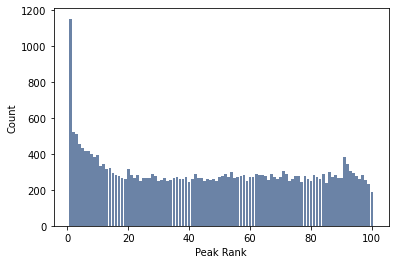

In [22]:
#Historgram that charts peak-rank for all songs (no duplications for songs
#that remain on the chart longer than one week)

peak_rank = all100_last_apperance_df['peak-rank'].value_counts().to_dict()

hist = thinkstats2.Hist(peak_rank)
thinkplot.Hist(hist)
thinkplot.Config(xlabel='Peak Rank', ylabel='Count')

Compare 2 scenarios using a PMF

In [23]:
top10_pmf = thinkstats2.Pmf(top10_longevity, label="top10")
bottom90_pmf = thinkstats2.Pmf(bottom90_longevity, label="bottom90")

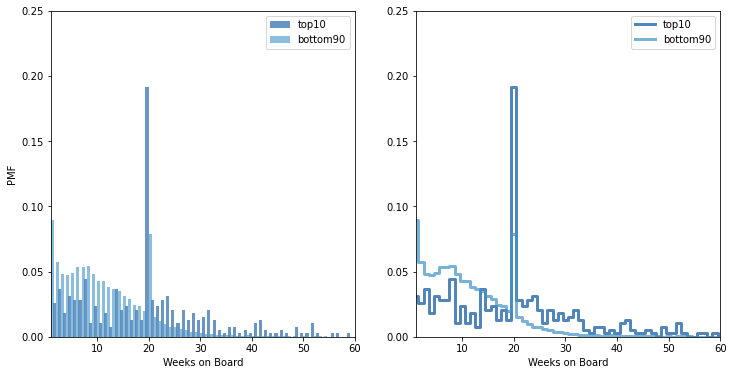

In [24]:
width = 0.6
axis = [1, 60, 0, 0.25]
thinkplot.PrePlot(2, cols=2)
thinkplot.Hist(top10_pmf, align="right", width=width)
thinkplot.Hist(bottom90_pmf, align="left", width=width)
thinkplot.Config(xlabel="Weeks on Board", ylabel="PMF", axis=axis)

thinkplot.PrePlot(2)
thinkplot.SubPlot(2)
thinkplot.Pmfs([top10_pmf, bottom90_pmf])
thinkplot.Config(xlabel="Weeks on Board", axis=axis)

Create CDF with one of the variables

In [26]:
top10_cdf = thinkstats2.Cdf(top10_longevity, label="top10")
bottom90_cdf = thinkstats2.Cdf(bottom90_longevity, label="bottom90")

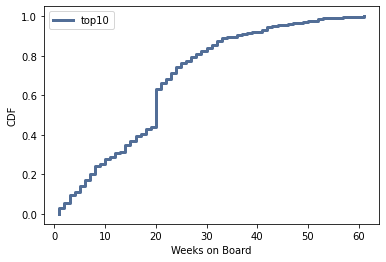

<Figure size 576x432 with 0 Axes>

In [27]:
thinkplot.Cdf(top10_cdf)
thinkplot.Show(xlabel='Weeks on Board', ylabel="CDF")

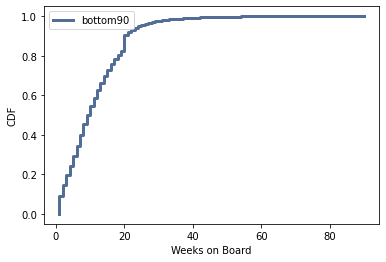

<Figure size 576x432 with 0 Axes>

In [28]:
thinkplot.Cdf(bottom90_cdf)
thinkplot.Show(xlabel='Weeks on Board', ylabel="CDF")

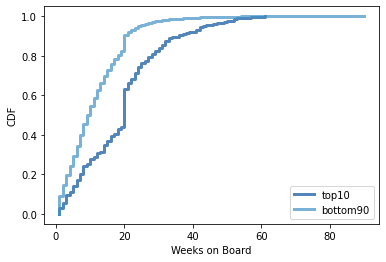

<Figure size 576x432 with 0 Axes>

In [29]:
thinkplot.PrePlot(2)
thinkplot.Cdfs([top10_cdf, bottom90_cdf])
thinkplot.Show(xlabel='Weeks on Board', ylabel='CDF')

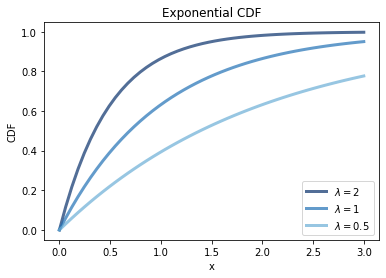

In [30]:
thinkplot.PrePlot(3)
for lam in [2.0, 1, 0.5]:
    xs, ps = thinkstats2.RenderExpoCdf(lam, 0, 3.0, 50)
    label = r"$\lambda=%g$" % lam
    thinkplot.Plot(xs, ps, label=label)

thinkplot.Config(title="Exponential CDF", xlabel="x", ylabel="CDF", loc="lower right")

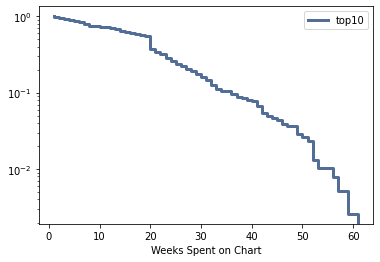

In [31]:
thinkplot.Cdf(top10_cdf, complement=True)
thinkplot.Config(
    xlabel="Weeks Spent on Chart",
    ylable="CCDF",
    yscale="log",
    loc="upper right",
)

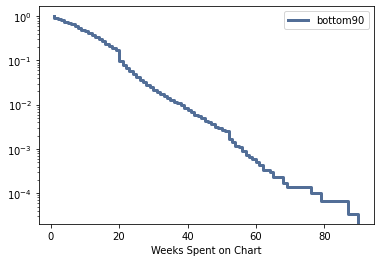

In [32]:
thinkplot.Cdf(bottom90_cdf, complement=True)
thinkplot.Config(
    xlabel="Weeks Spent on Chart",
    ylable="CCDF",
    yscale="log",
    loc="upper right",
)

Include Mean Mode Spread and Tails descriptive characteristics

- my initial placement and variable usage caused issues with my code, so I moved it below the visualization code 

In [33]:
final_rank_series = pd.Series(final_rank)
debut_rank_series = pd.Series(debut_rank)
peak_rank_series = pd.Series(peak_rank)
top10_longevity_series = pd.Series(top10_longevity)
bottom90_longevity_series = pd.Series(bottom90_longevity)

In [34]:
def compute_summary_statistics(rank_counts):
    """
    rank_counts (pd.Series): a series where index represents ranks and values
    represent their counts

    returns a dictionary containing summary statistics mean, median, mode, standard
    deviation, and skew
    """
    #expand ranks based on frequency
    expanded_ranks = rank_counts.index.repeat(rank_counts.values)
    
    #convert to numpy array
    expanded_ranks = np.array(expanded_ranks)
    
    #compute summary statistics
    mean_value = np.mean(expanded_ranks)
    median_value = np.median(expanded_ranks)
    mode_value = mode(expanded_ranks).mode[0]
    std_dev = np.std(expanded_ranks)
    skew_value = skew(expanded_ranks)
    
    return {
        'mean': mean_value,
        'median': median_value,
        'mode': mode_value,
        'standard_deviation': std_dev,
        'skew': skew_value
    }

In [35]:
final_stats = compute_summary_statistics(final_rank_series)
print(final_stats)

{'mean': 76.57248908296943, 'median': 85.0, 'mode': 100, 'standard_deviation': 21.67407680292174, 'skew': -0.7220353198858488}


In [36]:
debut_stats = compute_summary_statistics(debut_rank_series)
print(debut_stats)

{'mean': 80.23871445896779, 'median': 86.0, 'mode': 90, 'standard_deviation': 19.270528536854847, 'skew': -1.794657411337529}


In [37]:
peak_stats = compute_summary_statistics(peak_rank_series)
print(peak_stats)

{'mean': 46.60759153510245, 'median': 46.0, 'mode': 1, 'standard_deviation': 30.569371256145786, 'skew': 0.08005543492412191}


In [38]:
top10_stats = compute_summary_statistics(top10_longevity_series)
print(top10_stats)

{'mean': 19.419689119170986, 'median': 20.0, 'mode': 20, 'standard_deviation': 12.312638349102452, 'skew': 0.7620387110678363}


In [39]:
bottom90_stats = compute_summary_statistics(bottom90_longevity_series)
print(bottom90_stats)

{'mean': 11.036005989654234, 'median': 9.0, 'mode': 1, 'standard_deviation': 8.220389248884553, 'skew': 1.3255261863210792}


In [50]:
#code from Thinkstats2
def SampleRows(df, nrows, replace=False):
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    return sample

In [63]:
#merge data from debut week and final week for each song

debut_df = charts_df[charts_df['weeks-on-board'] == 1].copy()

debut_df['debut-rank'] = debut_df['rank']

max_weeks_df = charts_df.loc[charts_df.groupby(['song', 'artist'])['weeks-on-board'].idxmax()]

result_df = pd.merge(max_weeks_df, debut_df[['song', 'artist', 'debut-rank']], 
                     on=['song', 'artist'], how='left')

result_df.head()

,date,rank,song,artist,last-week,peak-rank,weeks-on-board,debut-rank
0,1990-08-11,91,"""B"" Girls",Young And Restless,83.0,54,15,84.0
1,1973-05-19,51,"""Cherry Cherry"" from Hot August Night",Neil Diamond,31.0,31,10,84.0
2,1973-12-08,62,"""Having A Party"" Medley",The Ovations (Featuring Louis Williams),56.0,56,9,99.0
3,1974-02-16,42,"""Joy"" Pt. I",Isaac Hayes,30.0,30,9,72.0
4,1977-04-16,83,"""Roots"" Medley",Quincy Jones,57.0,57,7,87.0


In [66]:
#test new dataframe
song_name = 'Girls Want Girls'

# Filter the dataframe for case-insensitive match
specific_song_df = result_df.loc[result_df['song'].str.lower() == song_name.lower()]

# Display the result
print(specific_song_df)

           date  rank              song                    artist  last-week  \
8280 2021-11-06    26  Girls Want Girls  Drake Featuring Lil Baby       26.0   

      peak-rank  weeks-on-board  debut-rank  
8280          2               8         2.0  


Create 2 scatter plots

In [59]:
sample = SampleRows(all100_last_apperance_df, 500)

In [67]:
sample2 = SampleRows(result_df, 500)

Text(0, 0.5, 'Debut Rank (All Songs)')

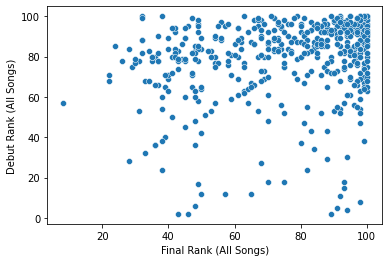

In [73]:
sns.scatterplot(x="rank", y="debut-rank", data=sample2)
plt.xlabel("Final Rank (All Songs)")
plt.ylabel("Debut Rank (All Songs)")

Text(0, 0.5, 'Debut Rank (All Songs)')

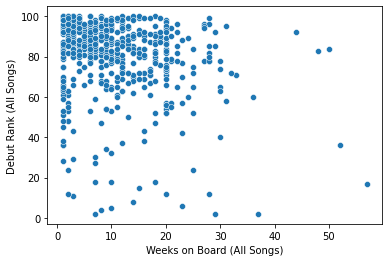

In [80]:
sns.scatterplot(x="weeks-on-board", y="debut-rank", data=sample2)
plt.xlabel("Weeks on Board (All Songs)")
plt.ylabel("Debut Rank (All Songs)")

Conduct a test on hypothesis

In [89]:
pearson_corr = result_df['debut-rank'].corr(result_df['weeks-on-board'], method='pearson')

print(f"Pearson's correlation between debut rank and weeks on board: {pearson_corr}")

Pearson's correlation between debut rank and weeks on board: -0.20180171975914268


In [90]:
pearson_corr = result_df['debut-rank'].corr(result_df['rank'], method='pearson')

print(f"Pearson's correlation between debut rank and final rank: {pearson_corr}")

Pearson's correlation between debut rank and final rank: 0.17635267870717566


Conduct regression analysis

In [91]:
import statsmodels.formula.api as smf

In [93]:
patsy_result_df = result_df.rename(columns={
    'weeks-on-board': 'weeks_on_board',
    'debut-rank': 'debutrank'
})

In [94]:
formula = 'weeks_on_board ~ debutrank'
model = smf.ols(formula, data=patsy_result_df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         weeks_on_board   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     1260.
Date:                Sat, 16 Nov 2024   Prob (F-statistic):          2.43e-270
Time:                        19:09:19   Log-Likelihood:            -1.0433e+05
No. Observations:               29684   AIC:                         2.087e+05
Df Residuals:                   29682   BIC:                         2.087e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     18.1002      0.202     89.546      0.000      17.704      18.496
debutrank     -0.0870      0.002    -35.498      0.000      -0.092      -0.082
==============================================================================
Omnibus:                     7522.779   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25546.724
Skew:                           1.267   Prob(JB):                         0.00
Kurtosis:                       6.772   Cond. No.                         353.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [95]:
inter = results.params['Intercept']
slope = results.params['debutrank']
inter, slope

(18.100243739565276, -0.08695193276247429)

In [96]:
slope_pvalue = results.pvalues['debutrank']
slope_pvalue

2.4295199955496187e-270

In [97]:
results.rsquared

0.04072393409774688

In [100]:
#Create "debut_top_10" DataFrame that only contains data for songs that fit these criteria:
#-'weeks-on-board' is '1'
#-'rank' is <= 10

top10debut = patsy_result_df[(patsy_result_df['weeks_on_board'] == 1) & (patsy_result_df['debutrank'] <= 10)]


#Create "debut_11_100" DataFrame that only contains data for songs that fit these criteria:
#-'weeks-on-board' is '1'
#-'rank' is > 10

bottom90debut = patsy_result_df[(patsy_result_df['weeks_on_board'] == 1) & (patsy_result_df['debutrank'] > 10)]


In [104]:
diff_weeks = top10debut.weeks_on_board.mean() - bottom90debut.weeks_on_board.mean()
diff_weeks

0.0

In [106]:
diff_debut = top10debut.debutrank.mean() - bottom90debut.debutrank.mean()
diff_debut

-71.60894278135657

In [107]:
slope * diff_debut

6.226535977916385

In [110]:
patsy_result_df['istop1'] = patsy_result_df.debutrank == 1
formula = 'weeks_on_board ~ istop1'
results = smf.ols(formula, data=patsy_result_df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         weeks_on_board   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     113.7
Date:                Sat, 16 Nov 2024   Prob (F-statistic):           1.73e-26
Time:                        19:26:28   Log-Likelihood:            -1.0495e+05
No. Observations:               29693   AIC:                         2.099e+05
Df Residuals:                   29691   BIC:                         2.099e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         11.1041      0.048    230.468      0.000      11.010      11.199
istop1[T.True]    11.5230      1.081     10.661      0.000       9.404      13.642
==============================================================================
Omnibus:                     7813.074   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25576.761
Skew:                           1.331   Prob(JB):                         0.00
Kurtosis:                       6.686   Cond. No.                         22.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [111]:
formula = 'weeks_on_board ~ istop1 + debutrank'
results = smf.ols(formula, data=patsy_result_df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         weeks_on_board   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     640.3
Date:                Sat, 16 Nov 2024   Prob (F-statistic):          5.72e-273
Time:                        19:27:38   Log-Likelihood:            -1.0432e+05
No. Observations:               29684   AIC:                         2.087e+05
Df Residuals:                   29681   BIC:                         2.087e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         17.9279      0.206     87.128      0.000      17.525      18.331
istop1[T.True]     4.7841      1.078      4.439      0.000       2.672       6.897
debutrank         -0.0849      0.002    -34.091      0.000      -0.090      -0.080
==============================================================================
Omnibus:                     7525.829   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25525.984
Skew:                           1.268   Prob(JB):                         0.00
Kurtosis:                       6.769   Cond. No.                     1.89e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.89e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [112]:
patsy_result_df['debutrank2'] = patsy_result_df.debutrank**2
formula = 'weeks_on_board ~ istop1 + debutrank + debutrank2'
results = smf.ols(formula, data=patsy_result_df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         weeks_on_board   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     456.0
Date:                Sat, 16 Nov 2024   Prob (F-statistic):          1.16e-289
Time:                        19:30:06   Log-Likelihood:            -1.0428e+05
No. Observations:               29684   AIC:                         2.086e+05
Df Residuals:                   29680   BIC:                         2.086e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         15.1619      0.365     41.486      0.000      14.446      15.878
istop1[T.True]     7.4477      1.115      6.680      0.000       5.262       9.633
debutrank          0.0183      0.012      1.586      0.113      -0.004       0.041
debutrank2        -0.0008   8.86e-05     -9.152      0.000      -0.001      -0.001
==============================================================================
Omnibus:                     7718.804   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26901.823
Skew:                           1.292   Prob(JB):                         0.00
Kurtosis:                       6.883   Cond. No.                     1.73e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.73e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""